In [2]:
from matminer.datasets import load_dataset
import pandas as pd
from pymatgen.ext.matproj import MPRester
from ase import Atoms
from pymatgen.io.ase import AseAtomsAdaptor
from dscribe.descriptors import SOAP
import numpy as np
import re
import pickle
import gzip
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer



## Band Gap energy
Load in the dft and experimental data. Convert dft compositional data to formula to match the experimental formula.

In [3]:
# load experimental data
df_exp = load_dataset('expt_gap_kingsbury')
df_exp = df_exp.dropna(subset=['likely_mpid'])
print(df_exp.shape)
display(df_exp.head())

# load DFT data
df_dft = load_dataset('jarvis_dft_3d')
df_dft = df_dft.drop(columns=['epsilon_x opt', 'epsilon_y opt', 'epsilon_z opt', 'shear modulus', 'bulk modulus', 'jid', 'epsilon_x tbmbj', 'epsilon_y tbmbj', 'epsilon_z tbmbj'])
df_dft['formula'] = df_dft['composition'].apply(lambda x: x.reduced_formula) # convert composition to formula
df_dft = df_dft.dropna()
print(df_dft.shape)
display(df_dft.head())

(2481, 3)


,likely_mpid,expt_gap,formula
1,mp-29717,0.00,Ag(W3Br7)2
5,mp-23558,0.00,Ag2BiO3
6,mp-9900,1.98,Ag2GeS3
8,mp-23485,2.47,Ag2HgI4
9,mp-1203404,3.06,Ag2Mo(I2O7)2


/Users/cadenmyers/miniconda3/envs/ml4ms/lib/python3.13/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/cadenmyers/miniconda3/envs/ml4ms/lib/python3.13/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/cadenmyers/miniconda3/envs/ml4ms/lib/python3.13/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


(7349, 8)


,structure,e_form,structure initial,gap tbmbj,mpid,gap opt,composition,formula
59,"[[ 8.9342299 3.79961599 -6.97400918] Mg, [ 3...",-2.896,"[[ 8.9825888 3.8061472 -7.01147537] Mg, [ 3...",7.8043,mp-6596,5.2711,"(Mg, Al, P, O)",MgAlPO5
68,"[[1.25762093 4.13616104 2.44785671] K, [3.7426...",-2.657,"[[1.26002845 4.20573168 2.5197491 ] K, [3.7544...",8.3622,mp-7324,5.6141,"(K, Be, P, O)",KBePO4
75,"[[3.1506963 4.30596127 3.56982179] As, [0.384...",0.025,"[[3.17888147 4.36479751 3.69558323] As, [0.381...",0.6495,mp-158,0.0221,(As),As
80,"[[0.37213617 3.67987527 0.87369073] H, [1.4889...",-1.184,"[[0.34436223 3.69323659 0.87470146] H, [1.4990...",0.0083,mp-24242,0.0038,"(H, O, F, Cu)",CuHOF
83,"[[ 0.92796672 1.82915421 10.16747299] O, [2.7...",-2.086,"[[ 0.938753 1.84002706 10.93783201] O, [2.8...",2.4642,mp-510584,1.9202,"(O, Mo)",MoO3


Create a dataframe of dft data for MP-ID's that are in both the experimental and dft datasets.

In [4]:
df_dft_filtered = df_dft[df_dft['mpid'].isin(df_exp['likely_mpid'])].reset_index(drop=True)
print(df_dft_filtered.shape)

(329, 8)


## Extract the total number of species in the dataset
This is necessary because our vector size for the algorithm must be the same shape. This ensures that the SOAP vector (see below) is of equal shape. Will will feed in all the species in a dataset. This will generate a lot of entries that are zero. This should be good for ML since its an additional source of information.

In [5]:
species_regex = r'[A-Z][a-z]*'  # Matches capital letter followed by lowercase letters

# Function to extract species from a single formula
def extract_species(formula):
    return set(re.findall(species_regex, formula))

# Function to extract species from a formula
def extract_species_from_df_column(df_column):
    # Apply the function to the dataframe column and get species
    all_species = set()
    species = df_column.apply(extract_species)
    # Collect all species into a single set
    for species_list in species:
        all_species.update(species_list)
    return list(all_species)

dft_unique_species = extract_species_from_df_column(df_dft['formula'])
print('Unique species in DFT data:', dft_unique_species)

exp_unique_species = extract_species_from_df_column(df_exp['formula'])
print('Unique species in experimental data:', exp_unique_species)

mpids = df_dft['mpid'].tolist() # list of mpids

Unique species in DFT data: ['Ga', 'Ni', 'Yb', 'V', 'U', 'W', 'N', 'Cd', 'Cu', 'Pa', 'Ne', 'Os', 'Ge', 'Tc', 'Be', 'In', 'Br', 'Ti', 'F', 'H', 'Mo', 'O', 'As', 'Au', 'Pt', 'K', 'Al', 'Na', 'Y', 'Zr', 'Pb', 'B', 'Dy', 'Kr', 'P', 'Ar', 'Sb', 'Ir', 'Sn', 'Cr', 'Li', 'Sr', 'Lu', 'Fe', 'Ta', 'Mn', 'C', 'Rb', 'La', 'He', 'Zn', 'Pr', 'Nb', 'Cl', 'Sm', 'Er', 'Co', 'Ba', 'Mg', 'Hg', 'Ce', 'S', 'Tl', 'Nd', 'I', 'Si', 'Ag', 'Hf', 'Rh', 'Re', 'Ru', 'Ho', 'Cs', 'Sc', 'Se', 'Tb', 'Bi', 'Tm', 'Te', 'Th', 'Ca', 'Pd']
Unique species in experimental data: ['Ga', 'Ni', 'Yb', 'V', 'U', 'W', 'N', 'Cd', 'Cu', 'Os', 'Ge', 'Tc', 'Be', 'In', 'Br', 'Ti', 'F', 'Mo', 'H', 'O', 'As', 'Au', 'Pt', 'K', 'Al', 'Na', 'Y', 'B', 'Pb', 'Dy', 'Zr', 'P', 'Sb', 'Ir', 'Sn', 'Cr', 'Li', 'Lu', 'Sr', 'Fe', 'Ta', 'Mn', 'Eu', 'C', 'La', 'Rb', 'Zn', 'Pr', 'Nb', 'Cl', 'Sm', 'Er', 'Co', 'Ba', 'Mg', 'Hg', 'Ce', 'S', 'Xe', 'Tl', 'Nd', 'I', 'Rh', 'Ag', 'Si', 'Re', 'Hf', 'Ru', 'Ho', 'Cs', 'Sc', 'Se', 'Gd', 'Tb', 'Bi', 'Tm', 'Te', 'Th', '

## Get bravais lattice and space group from MP-ID

In [ ]:
API_KEYcm = "cmeSCicjBiIc0Nk02lArDwjO4V0jyXKw" # get your API key by making a materials project account https://materialsproject.org/

mp_id = "mp-149"
def get_sg_and_bravais_lattice(mp_id, API_KEY=API_KEYcm):
    with MPRester(API_KEY) as mpr:
        structure = mpr.get_structure_by_material_id(mp_id)
        sga = SpacegroupAnalyzer(structure)
        bravais_lattice = sga.get_lattice_type()
        space_group = sga.get_space_group_symbol()
    return space_group, bravais_lattice


In [7]:
df = pd.read_csv('/Users/cadenmyers/billingelab/dev/ml4ms_bandgap_final/data/sg_data.csv')

df.head()

,formula,mpid,space group,bravais lattice,gap opt
0,MgAlPO5,mp-6596,P2_1/c,monoclinic,5.2711
1,KBePO4,mp-7324,Pna2_1,orthorhombic,5.6141
2,As,mp-158,Cmce,orthorhombic,0.0221
3,CuHOF,mp-24242,P2_1/c,monoclinic,0.0038
4,AgI,mp-567809,P4/nmm,tetragonal,1.2599


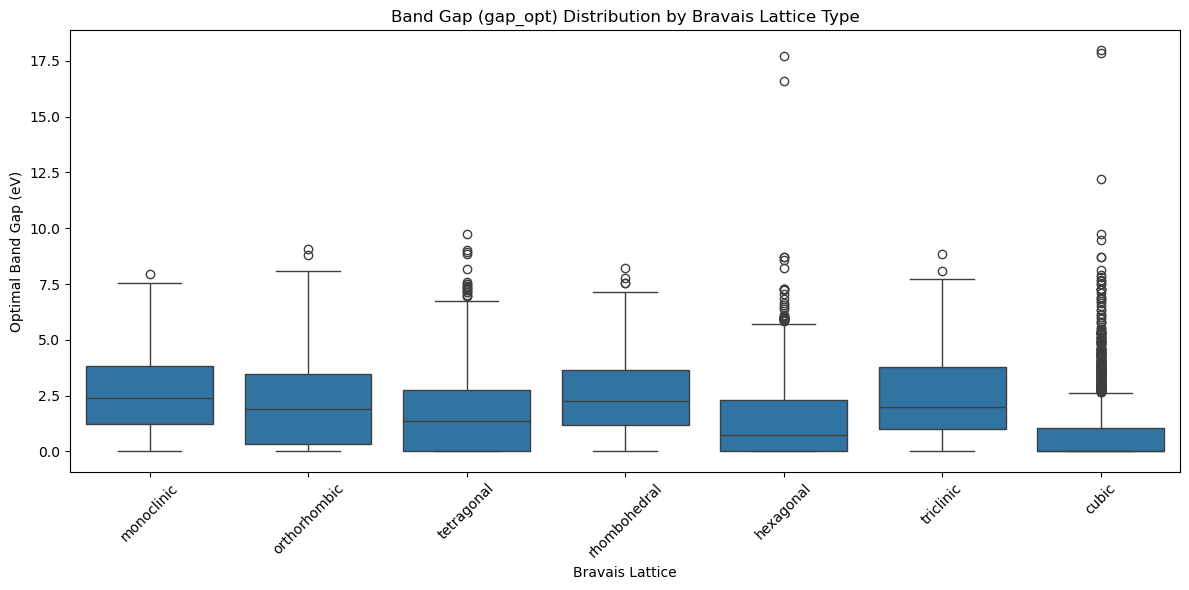

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="bravais lattice", y="gap opt")
plt.xticks(rotation=45)
plt.title("Band Gap (gap_opt) Distribution by Bravais Lattice Type")
plt.xlabel("Bravais Lattice")
plt.ylabel("Optimal Band Gap (eV)")
plt.tight_layout()
plt.show()

## Generate the SOAP descriptor

The **SOAP (Smooth Overlap of Atomic Positions)** descriptor is a powerful tool used in computational materials science to represent the local atomic environment of a material. It encodes information about the local symmetry and structure of atoms in a material, making it suitable for use in machine learning models that predict material properties.

### Key Features:
- **Local Environment Representation**: The SOAP descriptor captures the atomic environment around each atom in a structure, using a smooth overlap of atomic positions.
- **Spherical Harmonics**: The descriptor uses spherical harmonics to represent angular information, allowing it to effectively capture local symmetries.
- **Radial Basis Functions**: The radial part of the descriptor is represented using radial basis functions, which help model the distances between atoms.
- **Species Specific**: The descriptor can incorporate the chemical species present in the structure, allowing it to adapt to different materials.

### How It Works:
1. **Structure Representation**: The local atomic environment of each atom is represented by a combination of radial and angular functions.
2. **Cutoff Radius**: Only atoms within a certain cutoff radius contribute to the descriptor, ensuring computational efficiency.
3. **Smearing**: Gaussian smearing is used to smooth the atomic positions, ensuring a continuous representation.
4. **Periodic Structures**: SOAP can be used to model periodic structures such as crystals, making it suitable for large-scale materials simulations.


In [ ]:

def generate_soap_descriptor(mp_id, API_KEY=API_KEYcm):
    # 1. Connect to Materials Project
    mpr = MPRester(API_KEY)
    
    # 2. Fetch structure by MP-ID
    structure_pmg = mpr.get_structure_by_material_id(mp_id)

    # 3. Convert pymatgen structure to ASE Atoms
    ase_structure = AseAtomsAdaptor.get_atoms(structure_pmg)

    # 4. Check if species from provided list matches with the structure
    structure_species = list(set(ase_structure.get_chemical_symbols()))  # Unique elements in the structure
    
    # 5. Set up SOAP descriptor
    soap = SOAP(
        species=structure_species,   # List of elements present (user-specified)
        periodic=True,          # Is the structure periodic? (crystals = True, molecules = False)
        r_cut=5.0,              # Cutoff radius (Å)
        n_max=8,                # Number of radial basis functions
        l_max=6,                # Maximum degree of spherical harmonics
        sigma=0.5,              # Width (smearing) of Gaussians placed on atoms (Å)
        sparse=False            # Should output be dense NumPy array? (False = full array; True = sparse matrix for memory saving)
    )

    # 6. Create SOAP descriptors
    soap_descriptors = soap.create(ase_structure)

    return soap_descriptors

# print(mpids)
soap_descriptor = generate_soap_descriptor(mp_id=mpids[0])

print(soap_descriptor.shape)

Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4899.89it/s]

(32, 3696)


## Calculate Soap Descriptors
Below code generates soap descriptors for all mpids in the df_dft dataset and creates a dataframe

In [132]:
# # Generate SOAP descriptors for all mpids
# soap_dict = {}
# for i, mpid in enumerate(mpids):
#     try:
#         soap_descriptor = generate_soap_descriptor(mp_id=mpid)
#         soap_dict[df_dft['formula'].iloc[i]] = soap_descriptor
#         soap_dict[df_dft['mpid'].iloc[i]] = soap_descriptor
#     except Exception as e:
#         print(f"Skipping {mpid} due to error: {e}")

df_soap = pd.DataFrame({
    'formula': soap_dict.keys(),
    'soap_descriptor': soap_dict.values()
})
df_soap = df_soap.merge(df_dft[['formula', 'mpid']], on='formula', how='left')
df_soap.drop_duplicates(subset=['formula'], inplace=True)


## Zero padding SOAP descriptors

In [135]:
def find_largest_shape(soap_descriptors):
    """
    Find the largest shape of the SOAP descriptors.

    Parameters:
    soap_descriptors (list or pd.Series): List of numpy arrays representing SOAP descriptors.

    Returns:
    tuple: (max_x, max_y) - maximum x and y dimensions of the SOAP descriptors.
    """
    max_x = 0
    max_y = 0

    for desc in soap_descriptors:
        if desc is not None:
            shape = desc.shape
            if len(shape) >= 2:
                max_x = max(max_x, shape[0])
                max_y = max(max_y, shape[1])
    return max_x, max_y

max_x, max_y = find_largest_shape(df_soap['soap_descriptor'])
print(max_x, max_y)

def zero_pad_soap_descriptors(soap_descriptors, target_shape):
    """
    Zero-pad each SOAP descriptor to the target shape.

    Parameters:
    soap_descriptors (list or pd.Series): List of numpy arrays representing SOAP descriptors.
    target_shape (tuple): (target_x, target_y) shape to pad to.

    Returns:
    list: List of zero-padded numpy arrays.
    """
    padded_descriptors = []

    for desc in soap_descriptors:
        if desc is None:
            padded = np.zeros(target_shape)
        else:
            padded = np.zeros(target_shape)
            x_size = min(desc.shape[0], target_shape[0])
            y_size = min(desc.shape[1], target_shape[1]) if len(desc.shape) > 1 else 1

            # Copy data into padded array
            if len(desc.shape) == 1:
                padded[:x_size, 0] = desc[:x_size]
            else:
                padded[:x_size, :y_size] = desc[:x_size, :y_size]

        padded_descriptors.append(padded)

    return padded_descriptors

padded_descriptors = zero_pad_soap_descriptors(df_soap['soap_descriptor'], (max_x, max_y))

64 8232


In [167]:
soap_path = '/Users/cadenmyers/billingelab/dev/ml4ms_bandgap_final/data/soap_descriptors.pkl.gz'

# Reading a compressed .pkl file (e.g., .pkl.gz)
with gzip.open(soap_path, 'rb') as f:
    padded_df = pickle.load(f)

In [170]:
padded_df.head(50)

,formula,soap_descriptor,mpid,zero_padded_soap
0,MgAlPO5,"[[7.834700877986906e-05, -0.000248821014237357...",mp-6596,"[[7.834700877986906e-05, -0.000248821014237357..."
1,KBePO4,"[[1.224395792223083e-07, -5.548160208843811e-0...",mp-7324,"[[1.224395792223083e-07, -5.548160208843811e-0..."
2,As,"[[0.18087236729129627, 0.4693173276837286, 0.5...",mp-158,"[[0.18087236729129627, 0.4693173276837286, 0.5..."
4,CuHOF,"[[8.408499979827601e-07, -6.4356783799753e-06,...",mp-24242,"[[8.408499979827601e-07, -6.4356783799753e-06,..."
5,AgI,"[[0.18083827914220227, 0.4690888310062766, 0.5...",mp-567809,"[[0.18083827914220227, 0.4690888310062766, 0.5..."
12,ZrBrN,"[[1.6087614466449077e-05, -5.929285214217304e-...",mp-570157,"[[1.6087614466449077e-05, -5.929285214217304e-..."
13,InBr3,"[[3.8849510688717664e-07, 1.0707179561579893e-...",mp-570219,"[[3.8849510688717664e-07, 1.0707179561579893e-..."
14,YI3,"[[0.18204641291148752, 0.4670436680038411, 0.5...",mp-571442,"[[0.18204641291148752, 0.4670436680038411, 0.5..."
15,AlHO2,"[[5.891756608461837e-06, -2.8729819768613437e-...",mp-625055,"[[5.891756608461837e-06, -2.8729819768613437e-..."
24,BiOF,"[[3.730708030672268e-06, -2.0038238223605248e-...",mp-759883,"[[3.730708030672268e-06, -2.0038238223605248e-..."
